In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from music21 import *
import pandas as pd
from matplotlib import gridspec
import h5py
import json

import seaborn as sns
sys.path.append('.')
from latexify import *

import sys
sys.path.append('/home/fl350/bachbot/scripts')
from datasets import standardize_key
from constants import *

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
2 ** 0.323

1.2509290801132664

In [5]:
2 ** 0.477

1.3918463918311013

In [6]:
utf_to_txt = json.load(open('/home/fl350/bachbot/scratch/utf_to_txt.json'))
txt_to_utf = { v:k for k,v in utf_to_txt.items() }

checkpoint_fp = '/home/fl350/bachbot/best_model/checkpoint_200'
params = json.load(open(checkpoint_fp + '.json', 'r'))
vocabs = json.load(open(params['opt']['input_json'], 'r'))
vocab_size = len(vocabs['token_to_idx'])

In [7]:
fp = '/home/fl350/data/embed/input.h5'
input_data = h5py.File(fp)[fp].value.T
is_chord_bdy = input_data ==  vocabs['token_to_idx'][txt_to_utf[CHORD_BOUNDARY_DELIM]]

In [8]:
def pool_chords(ds, is_chord_bdy, pooling_method='max', softmax_before_pool=False, temperature=1.0):
    """
    Computes token probabilities and pools across chords. Useful for making dim 2 correspond to time.
    """
    pooled_probs = np.zeros((ds.shape[0], is_chord_bdy.sum()+1))
    curr_chord_idx = 0
    for i in range(is_chord_bdy.size):
        z = ds[:,i]
        if softmax_before_pool:
            z = np.exp(z / temperature) / sum(np.exp(z) / temperature)
        if pooling_method == 'max':
            pooled_probs[:,curr_chord_idx] = np.maximum(pooled_probs[:,curr_chord_idx], z)
        elif pooling_method == 'sum':
            pooled_probs[:,curr_chord_idx] += z
        else:
            raise Exception('Unknown pooling method: {}'.format(pooling_method))
        if is_chord_bdy[i,0]:
            curr_chord_idx += 1       
    return pooled_probs

In [9]:
def pool_matrix(mat, row_to_bin):
    "Pools the rows of `mat` using row_to_order"
    pooled = np.zeros((len(set(row_to_bin.values())), mat.shape[1]))
    for row_idx in range(mat.shape[0]):
        pooled[row_to_bin[row_idx],:] += mat[row_idx,:]
    return pooled

In [10]:
special_texts = [CHORD_BOUNDARY_DELIM, FERMATA_SYM, 'START', 'END']

txt_to_idx = dict(map(lambda x: (utf_to_txt[x[0]], x[1]), vocabs['token_to_idx'].items()))
idx_to_txt = { v:k for k,v in txt_to_idx.items() }
note_txt_to_idx = dict(filter(lambda x: x[0] not in special_texts, txt_to_idx.items()))

# mapping from idx in vocabulary (1-based) to sorted order index (for drawing piano roll)
# NOTE: caller usually needs to convert idx to be 0-based 
idx_to_order = dict()
curr_idx = 0
prev_midi = None
for note_txt, idx in sorted(note_txt_to_idx.items(), key=lambda x: eval(x[0])[0]): # sorted by pitch
    curr_midi = eval(note_txt)[0]
    #print prev_midi, curr_midi, (note_txt, curr_idx), 
    if prev_midi and curr_midi > prev_midi: # this collapses articulated and unarticulated version 
        curr_idx += 1
    idx_to_order[idx] = curr_idx
    prev_midi = curr_midi
for txt in special_texts:
    curr_idx += 1
    idx_to_order[vocabs['token_to_idx'][txt_to_utf[txt]]] = curr_idx
    
assert set(range(1,vocab_size+1)) == set(idx_to_order)
assert set(idx_to_order.values()) == set(range(len(set(idx_to_order.values()))))

txt_to_order = {utf_to_txt[tok]:idx_to_order[vocabs['token_to_idx'][tok]] for tok in vocabs['token_to_idx']}

In [11]:
# mapping from `order_idx` (i.e. row in piano roll) back to raw text, used for ylabels in piano roll
order_to_txt = {}
for idx, order in idx_to_order.items():
    txt = idx_to_txt[idx]
    if txt in special_texts:
        order_to_txt[order] = txt
    else:
        midiPitch = int(txt.split(',')[0][1:])
        n = note.Note()
        n.pitch.midi = midiPitch
        order_to_txt[order] = n.nameWithOctave

In [12]:
def plot_piano_roll(ax1, s, showRomanAnalysis=False):
    g = graph.PlotHorizontalBarPitchSpaceOffset(s)
    data, xTicks, _ = g._extractData()

    yPos = 0
    xPoints = [] # store all to find min/max
    yTicks = [] # a list of label, value pairs

    #colors = sns.color_palette("muted")
    colors = sns.color_palette("husl", 12)
    axRoman = ax1.twiny()

    keys = []
    i = 0
    for i, (key, points) in enumerate(data):
        keys.append(key)
        if len(points) > 0:
            yrange = (yPos + 1, 1)
            axRoman.broken_barh(points,
                            yrange,
                            facecolor=colors[i%len(colors)],
                            alpha=0.8)
            for xStart, xLen in points:
                xEnd = xStart + xLen
                for x in [xStart, xEnd]:
                    if x not in xPoints:
                        xPoints.append(x)
        yTicks.append([yPos + 1 * .5, key])
        yPos += 1
        i += 1

    xMin = min(xPoints)
    xMax = max(xPoints) 
    ax1.set_ylim(0, len(keys) * 1)
    ax1.set_xlim(xMin, xMax)
    axRoman.set_xlim(xMin, xMax)
    ax1.set_yticks(map(lambda x: x+1, zip(*yTicks)[0]))
    ax1.set_yticklabels(zip(*yTicks)[1])
    ax1.set_xticks(zip(*xTicks)[0])
    ax1.set_xticklabels(zip(*xTicks)[1])
    ax1.set_title('Piano roll')
    ax1.set_xlabel('Measure number')
    ax1.set_ylabel('Pitch')
    
    if showRomanAnalysis:
        ax1.set_title('')
        axRoman.set_xticks(romanTicks)
        axRoman.set_xticklabels(romanLabels)        
        axRoman.set_xlabel('music21 Roman numeral analysis')
        axRoman.grid(zorder=0)
    
    return ax1

### The test score used as network input

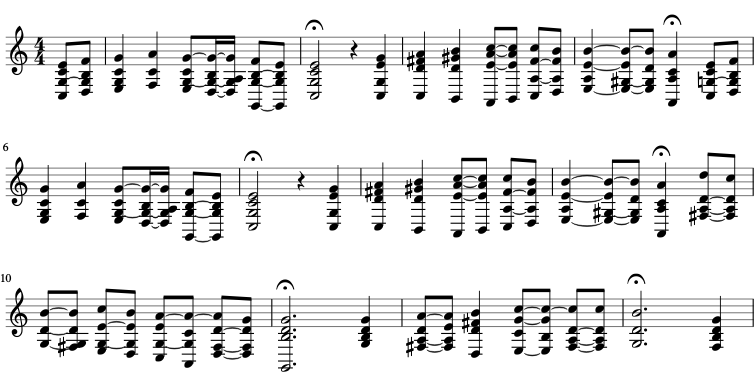

In [18]:
standardize_key(corpus.parse("bach","bwv133.6")).chordify().write('musicxml', '/home/fl350/data/embed/input.xml')
standardize_key(corpus.parse("bach","bwv133.6")).chordify().show()

In [15]:
s = converter.parseFile('/home/fl350/data/embed/input-full.xml')
_, xTicks, _ = graph.PlotHorizontalBarPitchSpaceOffset(s)._extractData()
sRoman = s.chordify().flat
for c in sRoman.notes:
    c.lyric =  roman.romanNumeralFromChord(c, key.Key('C')).romanNumeral
sRoman.write('musicxml','input-roman.xml')

romanTicks = []
romanLabels = []
for romanNum, note in zip(sRoman.lyrics()[1], sRoman.flat.notes):
    romanTicks.append(note.offset)
    romanLabels.append(romanNum.text)

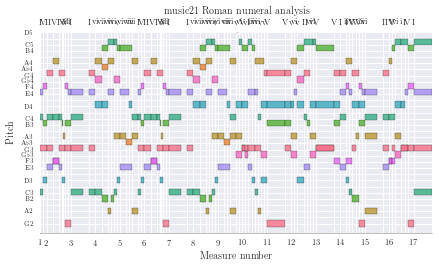

In [34]:
latexify(columns=2, ytick_labelsize=6)
#fig.set_size_inches((16,6))
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1)

plot_piano_roll(ax, s, showRomanAnalysis=True)

format_axes(ax)
fig.tight_layout()
fig.show()

## Layer Activations at token level

In [19]:
layerString="""
  (1): nn.LookupTable
  (2): nn.LSTM(32 -> 256)
  (3): nn.View(6400, -1)
  (4): nn.BatchNormalization
  (5): nn.View(50, 128, -1)
  (6): nn.Dropout(0.300000)
  (7): nn.LSTM(256 -> 256)
  (8): nn.View(6400, -1)
  (9): nn.BatchNormalization
  (10): nn.View(50, 128, -1)
  (11): nn.Dropout(0.300000)
  (12): nn.LSTM(256 -> 256)
  (13): nn.View(6400, -1)
  (14): nn.BatchNormalization
  (15): nn.View(50, 128, -1)
  (16): nn.Dropout(0.300000)
  (17): nn.View(6400, -1)
  (18): nn.Linear(256 -> 108)
  (19): nn.View(50, 128, -1)
""".strip()

layerNumToName = dict()
for st in layerString.split('\n'):
    parts = st.split(':')
    layerNum = int(parts[0].strip()[1:-1])
    layerName = parts[1][3:]
    layerNumToName[layerNum] = layerName

In [20]:
def plot_activations(data, fig, ax, colorbar=True):
    cax = ax.matshow(data, aspect='auto')
    ax.xaxis.set_ticks_position('bottom')
    if colorbar:
        fig.colorbar(cax)
    axRoman = ax.twiny()
    axRoman.set_xticks(romanTicks)
    axRoman.set_xticklabels(romanLabels)        
    axRoman.set_xlim([0, 64])
    fig.tight_layout()
    return axRoman

In [76]:
                outputs = np.exp(ds)/np.sum(np.exp(ds), 0)
                latexify(fig_width=10)
                #fig, ax = plt.subplots(1,1, figsize=(16,1+np.ceil(ds.shape[0] * 4. / 400.)))
                fig, ax = plt.subplots(1,1)
                axRoman = plot_activations(outputs, fig, ax)
                ax.set_ylabel('Next-token predictions')
                ax.set_xlabel('\# tokens processed')
                fig.savefig('model-analysis-tokens-{}.pgf'.format(figure_cnt), bbox_inches='tight', dpi=300)
                fig.show()
                figure_cnt += 1

IOError: [Errno 32] Broken pipe

IOError: [Errno 32] Broken pipe

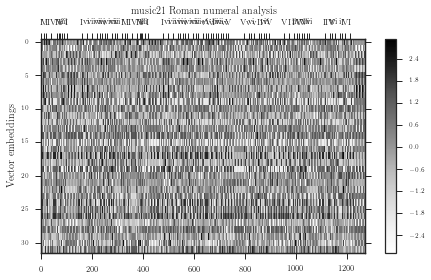

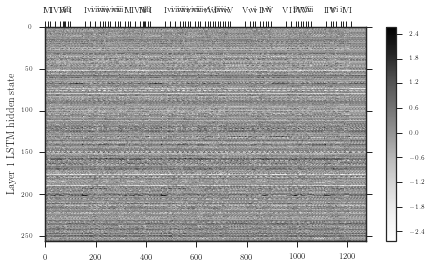

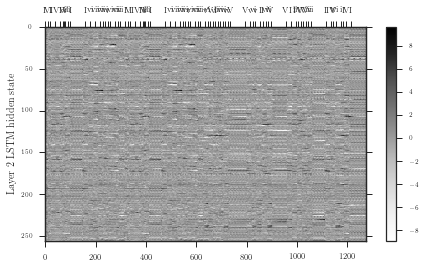

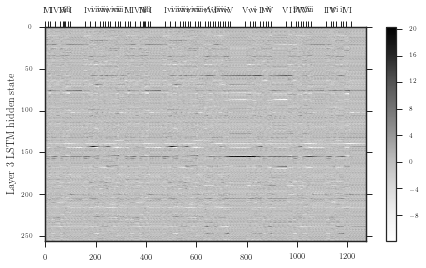

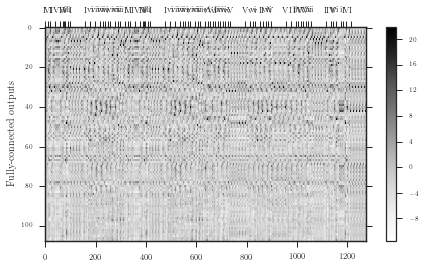

IOError: [Errno 32] Broken pipe

IOError: [Errno 32] Broken pipe

In [70]:
num_layers = len(layerNumToName)
lstm_cnt = 0
figure_cnt = 0
for layer in range(1,num_layers+1):
    fp = '/home/fl350/data/embed/outputs-{}.h5'.format(layer)
    
    cell_fp = os.path.dirname(fp) + '/cell-{}.h5'.format(layer)
    if os.path.exists(cell_fp):
        ds = h5py.File(cell_fp)[cell_fp].value.T
        lstm_cnt += 1
        with sns.axes_style('ticks'):
            latexify(columns=2)
            #fig, ax = plt.subplots(1,1, figsize=(16,1+np.ceil(ds.shape[0] * 4. / 400.)))
            fig, ax = plt.subplots(1,1)
            axRoman = plot_activations(ds, fig, ax)
            ax.set_ylabel('Layer {} LSTM hidden state'.format(lstm_cnt))
            fig.savefig('model-analysis-tokens-{}.pgf'.format(figure_cnt), bbox_inches='tight', dpi=300)
            figure_cnt += 1
            fig.show()
            
    if layer in [1, 19]:
        ds = h5py.File(fp)[fp].value.T
        with sns.axes_style('ticks'):
            latexify(columns=2)
            #fig, ax = plt.subplots(1,1, figsize=(16,1+np.ceil(ds.shape[0] * 4. / 400.)))
            fig, ax = plt.subplots(1,1)
            axRoman = plot_activations(ds, fig, ax)
            if layer == 1:
                ax.set_ylabel('Vector embeddings')
            elif layer == 19:
                ax.set_ylabel('Fully-connected  outputs')
            if layer == 1:
                axRoman.set_xlabel('music21 Roman numeral analysis')
            fig.savefig('model-analysis-tokens-{}.pgf'.format(figure_cnt), bbox_inches='tight', dpi=300)
            figure_cnt += 1
            plt.show()
            
            if layer == 19:
                outputs = np.exp(ds)/np.sum(np.exp(ds), 0)
                latexify(columns=2)
                #fig, ax = plt.subplots(1,1, figsize=(16,1+np.ceil(ds.shape[0] * 4. / 400.)))
                fig, ax = plt.subplots(1,1)
                axRoman = plot_activations(outputs, fig, ax)
                ax.set_ylabel('Next-token predictions')
                ax.set_xlabel('\# tokens processed')
                fig.savefig('model-analysis-tokens-{}.pgf'.format(figure_cnt), bbox_inches='tight', dpi=300)
                figure_cnt += 1
                #fig.show()

### Pooled over frames (i.e. one step in x-axis corresponds to 1/16th note)

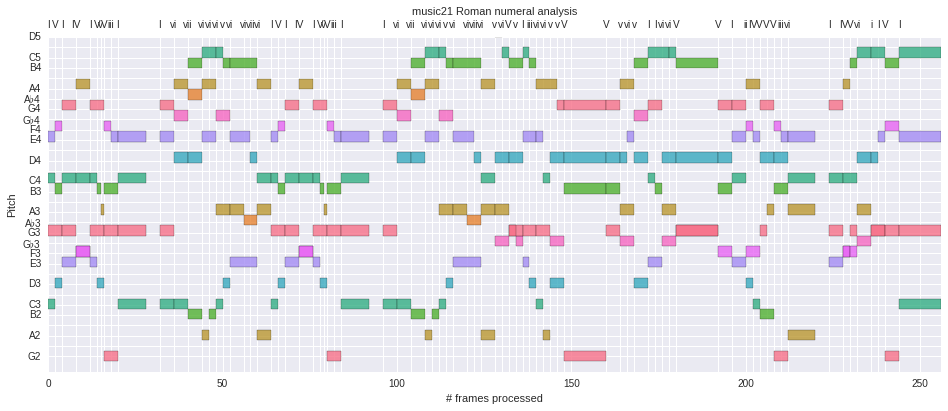

In [22]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    plot_piano_roll(ax, s, showRomanAnalysis=True)
    ax.set_xticks(np.arange(0,256,12.5))
    ax.set_xticklabels(np.arange(0,256,50))
    ax.set_xlim([0, 64])
    ax.set_xlabel('# frames processed')
    fig.show()
    #fig.savefig('model-analysis-cells-frame-piano-roll.png')

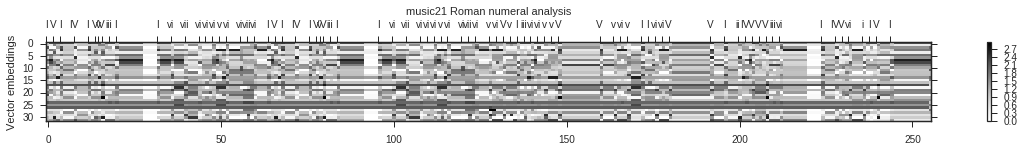

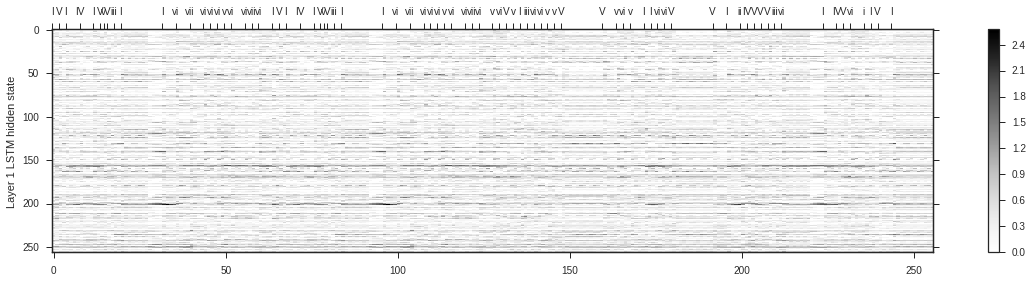

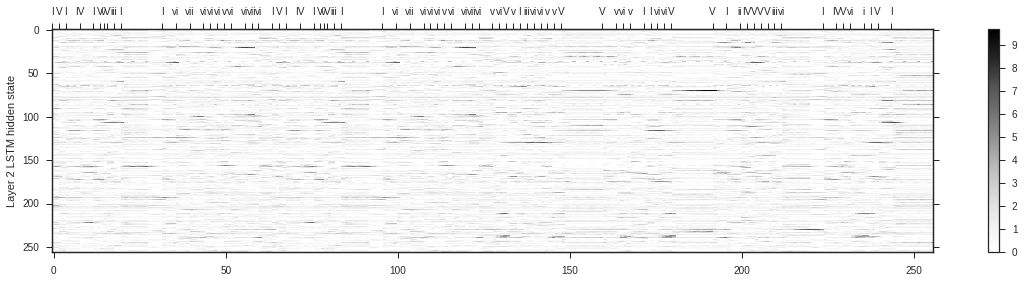

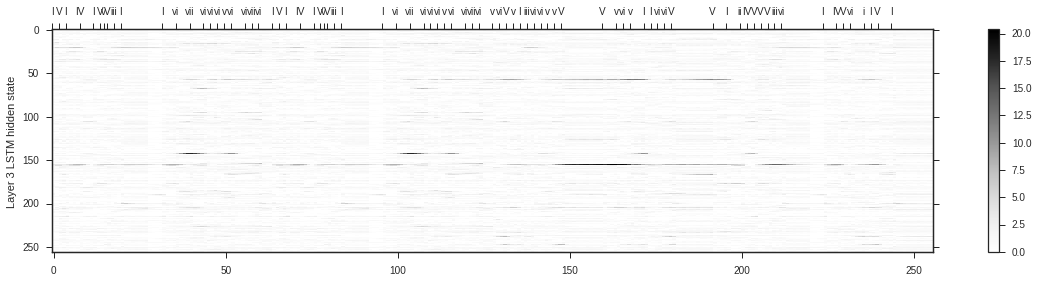

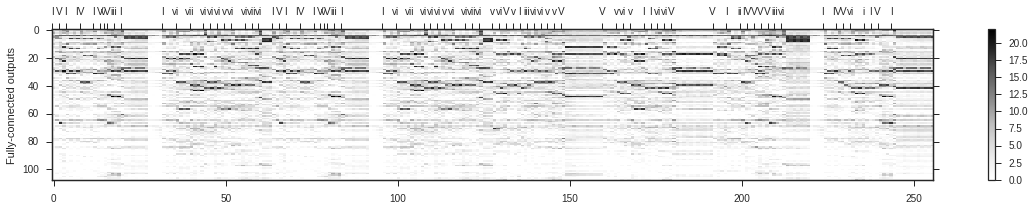

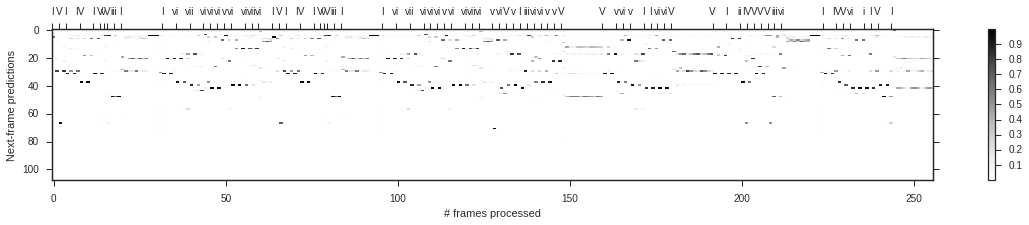

In [23]:
num_layers = len(layerNumToName)
lstm_cnt = 0
figure_cnt = 0

for layer in range(1,num_layers+1):
    fp = '/home/fl350/data/embed/outputs-{}.h5'.format(layer)
    
    cell_fp = os.path.dirname(fp) + '/cell-{}.h5'.format(layer)
    if os.path.exists(cell_fp):
        ds = h5py.File(cell_fp)[cell_fp].value.T
        ds_pooled = pool_chords(ds, is_chord_bdy, softmax_before_pool=False)
        lstm_cnt += 1
        with sns.axes_style('ticks'):
            fig, ax = plt.subplots(1,1, figsize=(16,1+np.ceil(ds.shape[0] * 4. / 400.)))
            axRoman = plot_activations(ds_pooled, fig, ax)
            ax.set_ylabel('Layer {} LSTM hidden state'.format(lstm_cnt))
            if layer == 1:
                axRoman.set_xlabel('music21 Roman numeral analysis')
            fig.savefig('model-analysis-chords-{}.png'.format(figure_cnt), bbox_inches='tight', dpi=300)
            figure_cnt += 1
            fig.show()
    if layer in [1, 19]:
        ds = h5py.File(fp)[fp].value.T
        ds_pooled = pool_chords(ds, is_chord_bdy, softmax_before_pool=False)
        with sns.axes_style('ticks'):
            fig, ax = plt.subplots(1,1, figsize=(16,1+np.ceil(ds.shape[0] * 4. / 400.)))
            axRoman = plot_activations(ds_pooled, fig, ax)
            if layer == 1:
                ax.set_ylabel('Vector embeddings')
            elif layer == 19:
                ax.set_ylabel('Fully-connected outputs')
            if layer == 1:
                axRoman.set_xlabel('music21 Roman numeral analysis')
            fig.savefig('model-analysis-chords-{}.png'.format(figure_cnt), bbox_inches='tight', dpi=300)
            figure_cnt += 1
            fig.show()
            
            if layer == 19:                
                fig, ax = plt.subplots(1,1, figsize=(16,1+np.ceil(ds.shape[0] * 4. / 400.)))
                axRoman = plot_activations(np.exp(ds_pooled) / np.sum(np.exp(ds_pooled), 0), fig, ax)
                ax.set_ylabel('Next-frame predictions')
                ax.set_xlabel('# frames processed')
                fig.savefig('model-analysis-chords-{}.png'.format(figure_cnt), bbox_inches='tight', dpi=300)
                figure_cnt += 1
                fig.show()

### Confirm that final outputs correspond to a piano roll

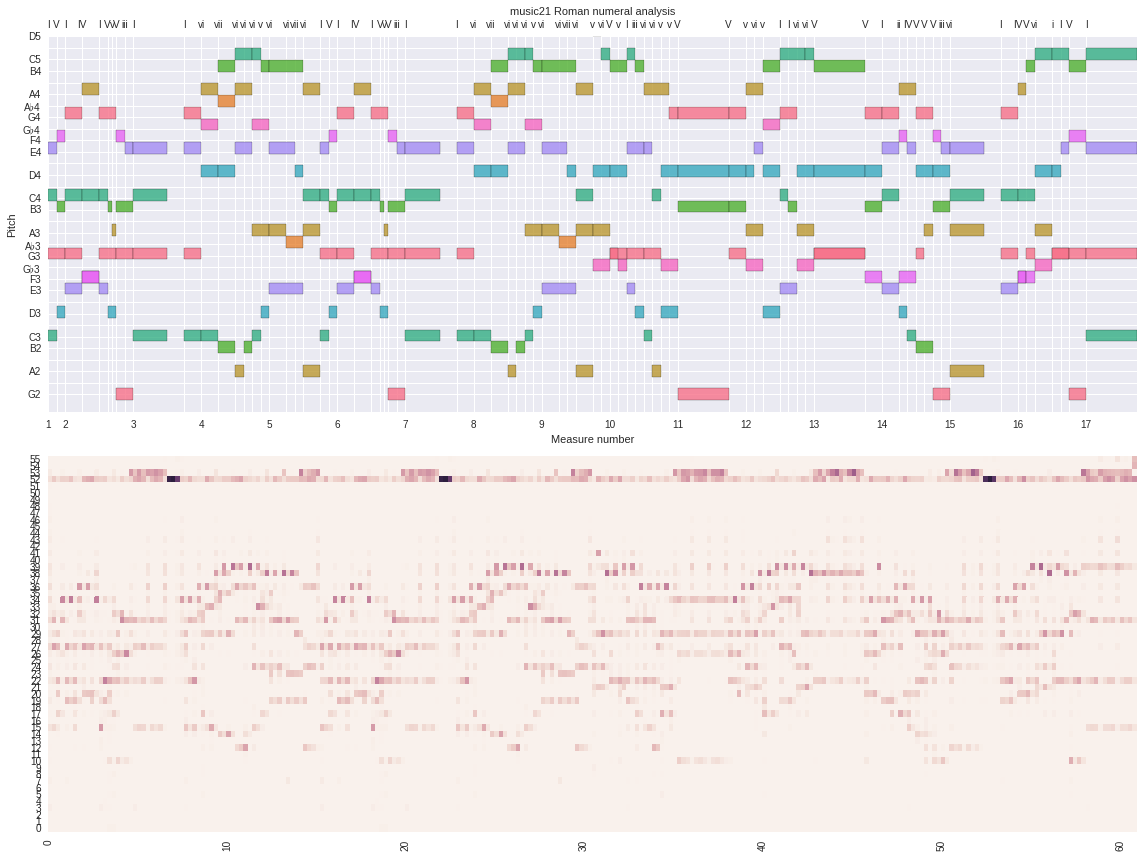

In [24]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2) = plt.subplots(2,1)

plot_piano_roll(ax1, s, showRomanAnalysis=True)

layer = 19
fp = '/home/fl350/data/embed/outputs-{}.h5'.format(layer)
ds = h5py.File(fp)[fp].value.T

pooled_probs = pool_chords(ds, is_chord_bdy, softmax_before_pool=True, temperature=1.5)
mat_z = pool_matrix(pooled_probs[:,:], { k-1:v for k,v in idx_to_order.items() }) # combine articulated/unarticulated
mat_p = mat_z / mat_z.sum(0) # normalize
#mat_p = np.exp(mat_z) / np.exp(mat_z).sum(0)

#ax2.matshow(mat_p, aspect='auto', interpolation='none')
sns.heatmap(mat_p, ax=ax2, cbar=False)

ax2.invert_yaxis()
ax2.set_xticks(np.arange(0,mat_z.shape[1],42))
ax2.set_xticklabels(np.arange(0, mat_z.shape[1]/4, 10))
#ax2.set_title('Probabilistic piano roll predictions for next chords')

fig.set_size_inches((16,12))
fig.tight_layout()
fig.show()

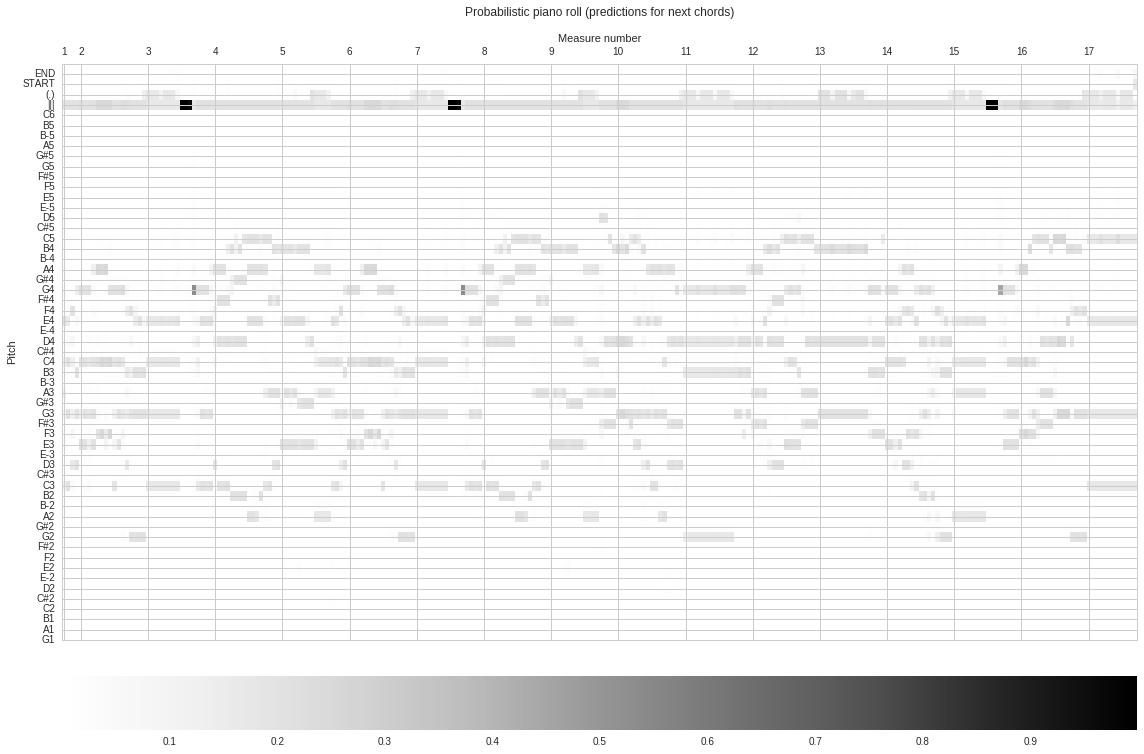

In [25]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,1)

layer = 19
fp = '/home/fl350/data/embed/outputs-{}.h5'.format(layer)
ds = h5py.File(fp)[fp].value.T

pooled_probs = pool_chords(ds, is_chord_bdy, pooling_method='max', softmax_before_pool=True, temperature=1.0)
mat_z = pool_matrix(pooled_probs[:,:], {k-1:v for k,v in idx_to_order.items()}) # combine articulated/unarticulated
mat_p = mat_z / mat_z.sum(0) # normalize

cax = ax.matshow(mat_p, aspect='auto', interpolation='none')
fig.colorbar(cax, orientation='horizontal', pad=0.05)
#sns.heatmap(mat_p, ax=ax, cbar=True)

ax.invert_yaxis()
ax.set_xticks(map(lambda x: 4*x, zip(*xTicks)[0]))
ax.set_xticklabels(zip(*xTicks)[1])
ax.set_title('Probabilistic piano roll (predictions for next chords)\n')
ax.set_xlabel('Measure number')
ax.xaxis.set_label_position('top')
ax.set_ylabel('Pitch')
ax.set_ylim([9,len(order_to_txt)])
ax.set_yticks(map(lambda x: x, np.arange(len(order_to_txt))))
ax.set_yticklabels(map(lambda idx: order_to_txt[idx], range(len(order_to_txt))))

fig.set_size_inches((16,11))
fig.tight_layout()
fig.show()
fig.savefig('model-analysis-probabilistic-piano-roll.png', bbox_inches='tight', dpi=300)

## Look at neuron activations

In [29]:
def plot_neuron(ax, neuron, showRomanLabels=False):
    axRoman = ax.twiny()
    axRoman.plot(neuron)
    if showRomanLabels:
        axRoman.set_xticks(map(lambda x: 4*x, romanTicks))
        axRoman.set_xticklabels(romanLabels)        
        axRoman.set_xlim(xmax=neuron.shape[0])
    ax.set_xlim(xmax=neuron.shape[0])
    return ax

In [27]:
def load_lstm_cell(fp, pooling_method='max', softmax_before_pool=True, temperature=1.0):
    return pool_chords(h5py.File(fp)[fp].value.T, is_chord_bdy,
                       pooling_method=pooling_method,
                       softmax_before_pool=softmax_before_pool,
                       temperature=temperature)

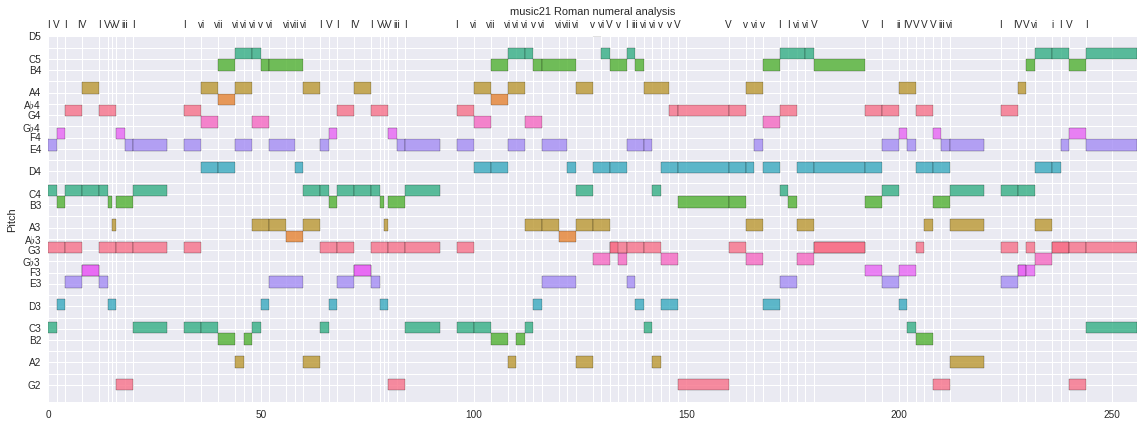

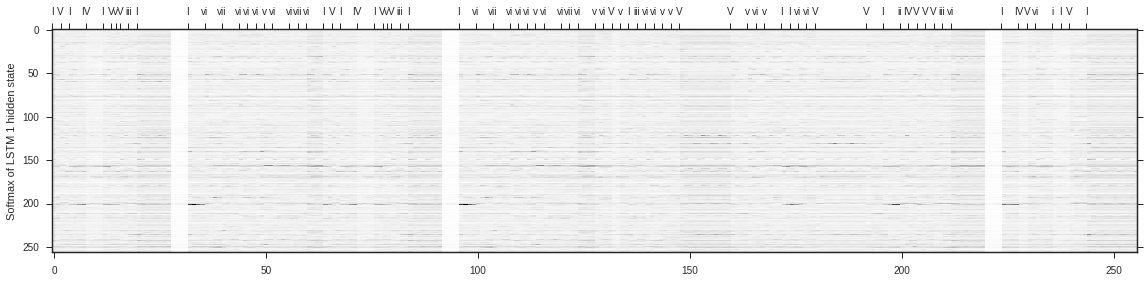

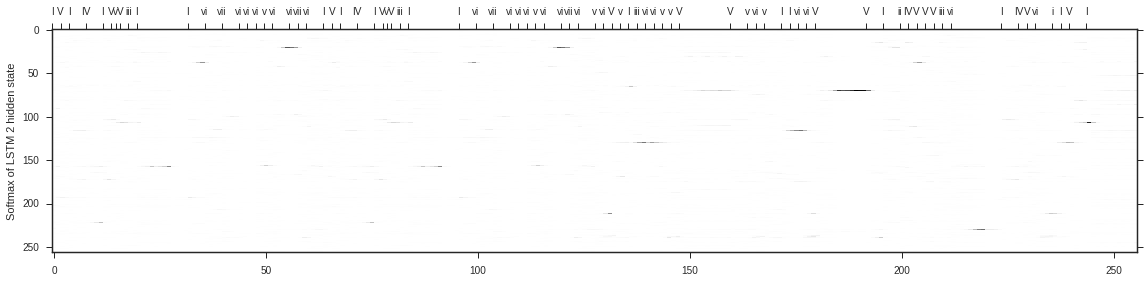

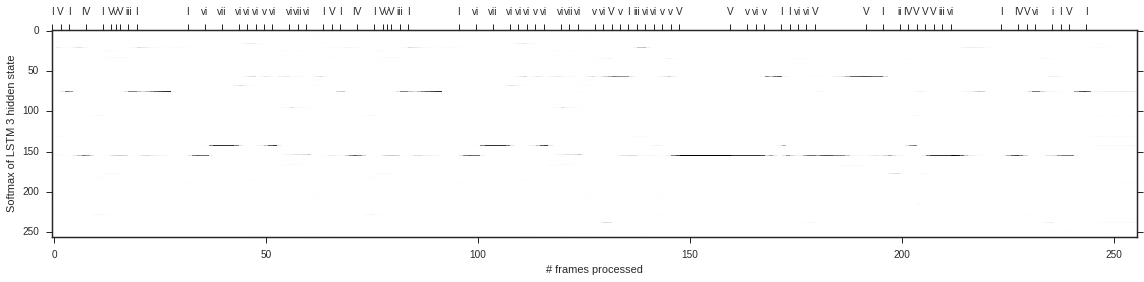

In [30]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    plot_piano_roll(ax, s, showRomanAnalysis=True)
    ax.set_xticks(np.arange(0,256,12.5))
    ax.set_xticklabels(np.arange(0,256,50))
    ax.set_xlim([0, 64])
    ax.set_xlabel('')
    fig.show()
    fig.tight_layout()
    fig.savefig('model-analysis-cells-softmax-piano-roll.png')
    
lstms = map(
    lambda fp: load_lstm_cell(fp, pooling_method='sum', softmax_before_pool=True, temperature=1.0),
    ['/home/fl350/data/embed/cell-2.h5',
    '/home/fl350/data/embed/cell-7.h5',
    '/home/fl350/data/embed/cell-12.h5'])

with sns.axes_style('ticks'):
    for i,cell in enumerate(lstms):
        fig, ax = plt.subplots(1,1, figsize=(16,4))
        axRoman = plot_activations(cell, fig, ax, colorbar=False)
        if i == 2:
            ax.set_xlabel('# frames processed')
        ax.set_ylabel('Softmax of LSTM {} hidden state'.format(i+1))
        fig.tight_layout()
        fig.show()
        fig.savefig('model-analysis-cells-softmax-{}.png'.format(i+1), bbox_inches='tight', dpi=300)

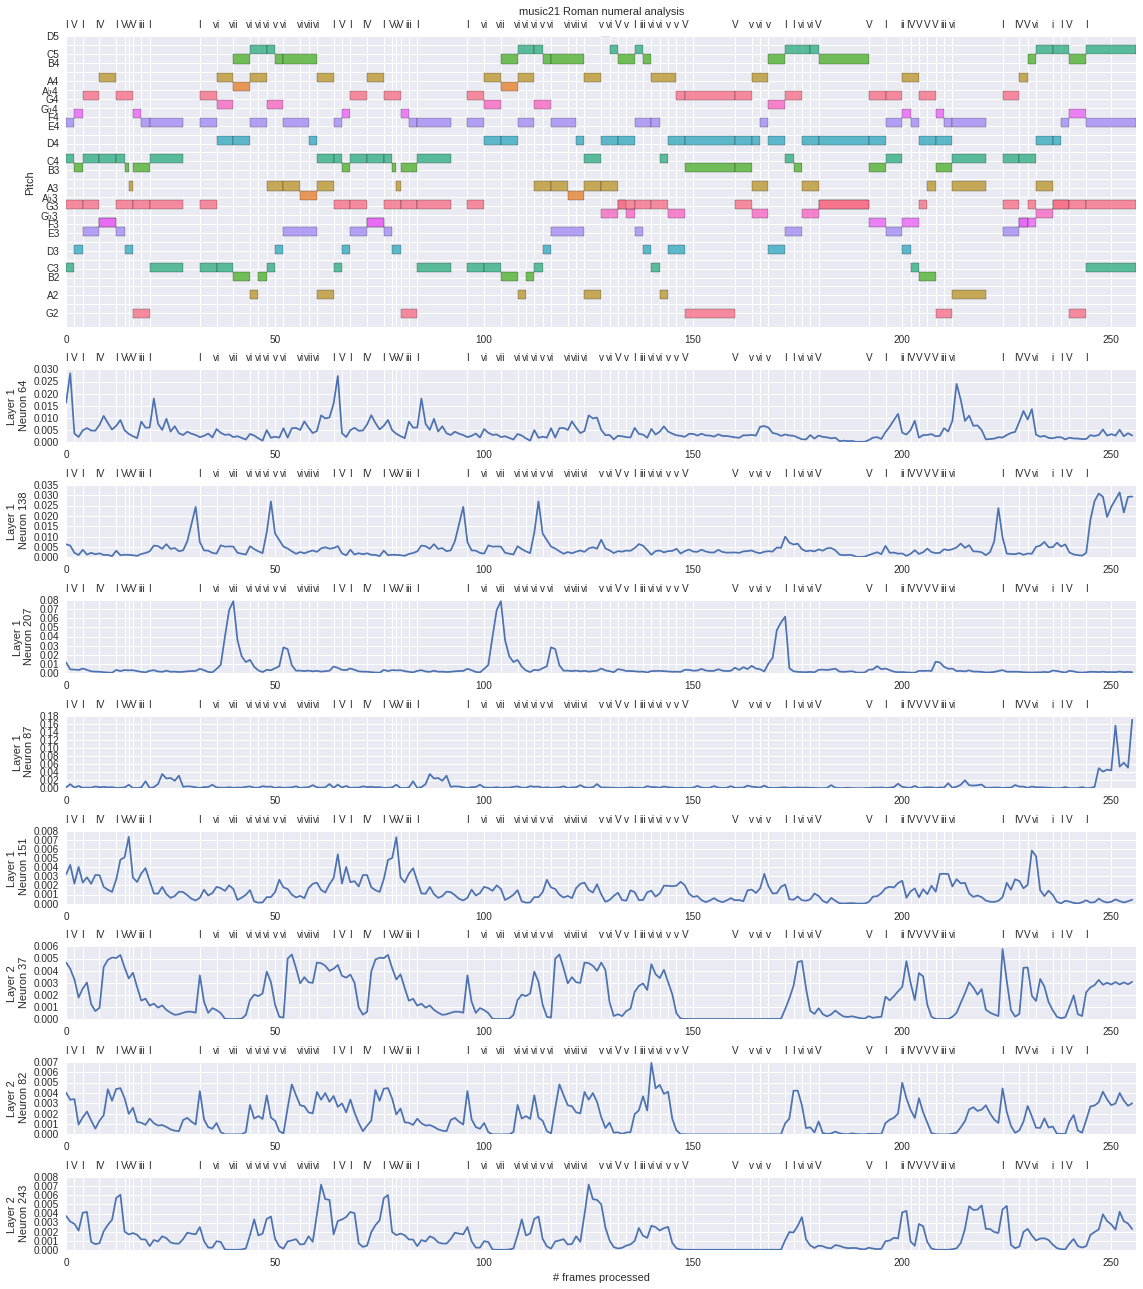

In [31]:
lstms = map(
    lambda fp: load_lstm_cell(fp, pooling_method='max', softmax_before_pool=True, temperature=1.),
    ['/home/fl350/data/embed/cell-2.h5',
    '/home/fl350/data/embed/cell-7.h5',
    '/home/fl350/data/embed/cell-12.h5'])

neurons = [
    (1,64), # V-I detector
    (1,138), # V-I detector
    (1,207), # V detector, inversion and duration sensitive
    (1,87), # spike on I V I, small excitation on I and V
    (1,151), # motif detector
    (2,37), # I, IV transitions
    (2,82), # chord progression peaking at vi
    (2,243),# vi, v, vi
] 


with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1+len(neurons),1, gridspec_kw = {'height_ratios':[4] + [1]*len(neurons)})
    
    plot_piano_roll(ax[0], s, showRomanAnalysis=True)
    ax[0].set_xticks(np.arange(0,256,12.5))
    ax[0].set_xticklabels(np.arange(0,256,50))
    ax[0].set_xlim([0, 64])
    ax[0].set_xlabel('')
    #ax[0].set_title('Neuron activations to applied stimulus\n\n\n')

for i,neuron in enumerate(neurons):
    layer, num = neuron
    #ax[1+i].plot(lstms[layer][num:num+1].T)
    plot_neuron(ax[1+i], lstms[layer][num:num+1].T, showRomanLabels=True)
    ax[1+i].set_ylabel('Layer {}\n Neuron {}'.format(layer, num))

ax[1+i].set_xlabel('# frames processed')
    
fig.set_size_inches((16,18))
fig.tight_layout()
fig.show()
plt.savefig('model-analysis-cells-individual.png', bbox_inches='tight', dpi=300)

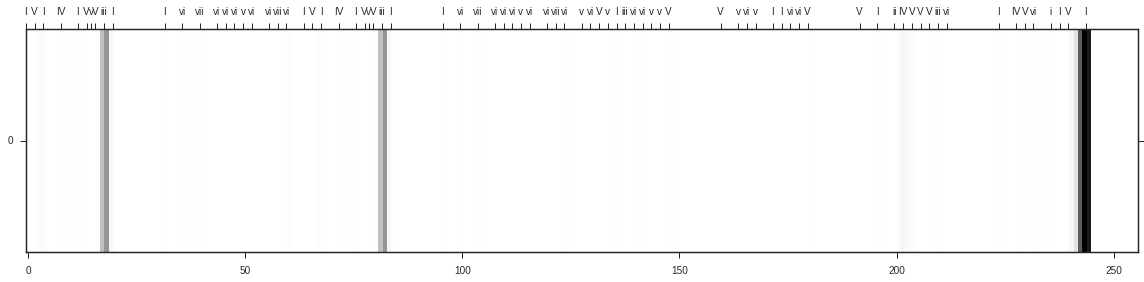

In [25]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,1, figsize=(16,4))
    axRoman = plot_activations(lstms[1][64:65], fig, ax, colorbar=False)
    fig.tight_layout()
    fig.show()